In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spectral_occupancy
import remove_DC_spike
import glob
from turbo_seti import find_event as find
from tqdm import trange

In [2]:
%matplotlib inline

First, I will look at how `spectral_occupancy.py` calculates histograms, to check if changes need to be made. ~I suspect that I will need to make fixed boundaries over which to calculate the histograms~ -- Done.

In [3]:
raw_dat_files = glob.glob("L_band_no_DC_spike/*.dat")

In [4]:
lengths = []
for i in trange(len(raw_dat_files)):
    hist, bins = spectral_occupancy.calculate_hist(raw_dat_files[i], "L")
    lengths.append(len(hist))

100%|██████████| 141/141 [00:16<00:00,  8.73it/s]


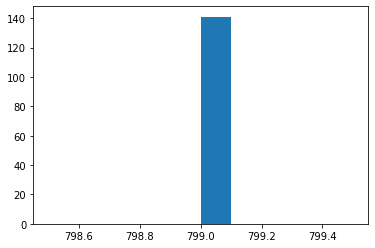

In [5]:
plt.figure()
_ = plt.hist(lengths)

I am indeed making fixed boundaries for the histograms. ~I need to determine what a good fixed boundary looks like for each band.~ The frequency boundaries were chosed based on the frequencies in [Traas et al, 2021](https://arxiv.org/abs/2101.11137).

In [6]:
# note these files are stored on blpc1
dirpath = "/datax/scratch/danielb/raffy_gbt/"
L = dirpath + "full_lband/"
S = dirpath + "full_sband/"
C = dirpath + "full_cband/"
X = dirpath +  "full_xband/"

In [7]:
l_dat = glob.glob(L+"*.dat")
s_dat = glob.glob(S+"*.dat")
c_dat = glob.glob(C+"*.dat")
x_dat = glob.glob(X+"*.dat")

## Determining the min/max frequencies of GBT band data

In [8]:
def min_max(band):
    maxs, mins = [],[]
    for file in band:
        tbl = find.read_dat(file)
        freqs = tbl["Freq"]
        maxs.append(max(freqs))
        mins.append(min(freqs))
    return min(mins), max(maxs)

In [9]:
min_max(l_dat)

(1024.074792, 1926.269528)

In [10]:
min_max(s_dat)

(1819.688629, 2719.335938)

In [11]:
min_max(c_dat)

(3947.802147, 8201.410912)

In [12]:
min_max(x_dat)

(7798.828125, 11101.936704)

In [13]:
min_max(raw_dat_files)

(1024.074793, 1926.269529)

Now that I have code that assumes a uniform start/stop frequency, I will now generate the histograms for a large number of files. I have arbitrarily chosen to work with L-band data; any of the bands would have been fine, but I am most familiar with seeing the results from L-band data. 

In [14]:
all_hist = []
file_lengths = []
for i in trange(len(l_dat)):
    hist, _ = spectral_occupancy.calculate_hist(l_dat[i], "L")
    tbl = find.read_dat(l_dat[i])
    file_lengths.append(len(tbl))
    all_hist.append(hist)
all_hist = np.asarray(all_hist)

100%|██████████| 141/141 [00:30<00:00,  4.64it/s]


It may be worth knowing the length of the dat files, to know how many hits are typical for a given observation.

In [15]:
n_files = len(file_lengths)
avg = np.mean(file_lengths)
median = np.median(file_lengths)
std = np.std(file_lengths)
minimum = np.min(file_lengths)
maximum = np.max(file_lengths)

print("We are working with %s .dat files\n"%n_files)
print("Avg:    %s"%avg)
print("Median: %s"%median)
print("SD:     %s"%std)
print("min:    %s"%minimum)
print("max:    %s"%maximum)

We are working with 141 .dat files

Avg:    6965.404255319149
Median: 6252.0
SD:     3493.212799025085
min:    2
max:    25711


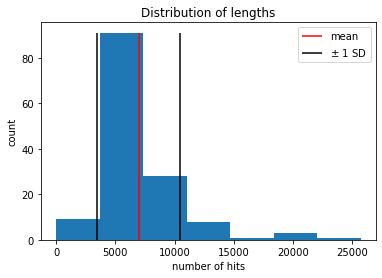

In [16]:
n_bins = int(np.round(np.log(len(file_lengths))/np.log(2)))
plt.figure()
_ = plt.hist(file_lengths, bins=n_bins)
plt.vlines(avg, 0, max(_[0]), color="red", label="mean")
plt.vlines(avg-std, 0, max(_[0]))
plt.vlines(avg+std, 0, max(_[0]), label=r"$\pm$ 1 SD")
plt.legend()
plt.title("Distribution of lengths")
plt.xlabel("number of hits")
plt.ylabel("count");

Now I will calculate the long-term mean and standard deviation of the hits per bin and compare it to a single dat file. 

In [17]:
all_hist.shape

(141, 799)

In [18]:
transposed = all_hist.T
means, sds = [],[]
for freq in transposed:
    one_mean = np.mean(freq)
    one_sd = np.std(freq)
    
    means.append(one_mean)
    sds.append(one_sd)

means = np.asarray(means)
sds = np.asarray(sds)

I am curious if there is a relation between the number of hits and the standard deviation. Based on the scatter below, it doesn't look like ther is much of a relation. 

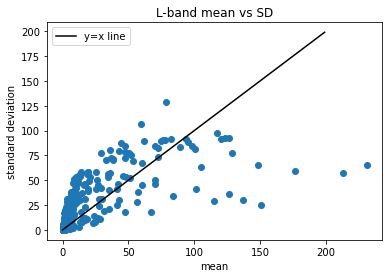

In [19]:
x = np.linspace(1100, 1900, num=len(means))
y = np.arange(200)
plt.figure()
plt.scatter(means, sds)
plt.xlabel("mean")
plt.ylabel("standard deviation")
plt.plot(y,y, color="black", label="y=x line")
plt.legend()
plt.title("L-band mean vs SD");

Now I will try plotting up the mean and standard deviation of the data and compare it to the plot of a single .dat file.

In [20]:
one_dat = l_dat[0]
dat_tbl = find.read_dat(one_dat)
max(dat_tbl["CoarseChanNum"])

307

In [21]:
hist, bins = spectral_occupancy.calculate_hist("dummy string", "L", tbl=tbl)

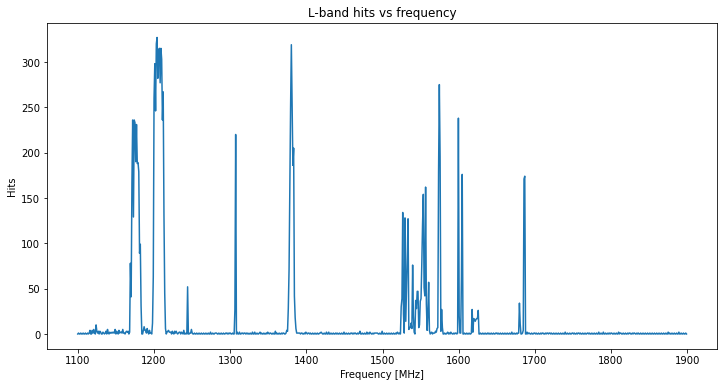

In [22]:
# single dat file histogram
plt.figure(figsize=(12,6))
plt.plot(bins[:-1], hist)
plt.title("L-band hits vs frequency")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Hits")
plt.savefig("one_dat_file_hist.pdf")
plt.savefig("one_dat_file_hist.png");

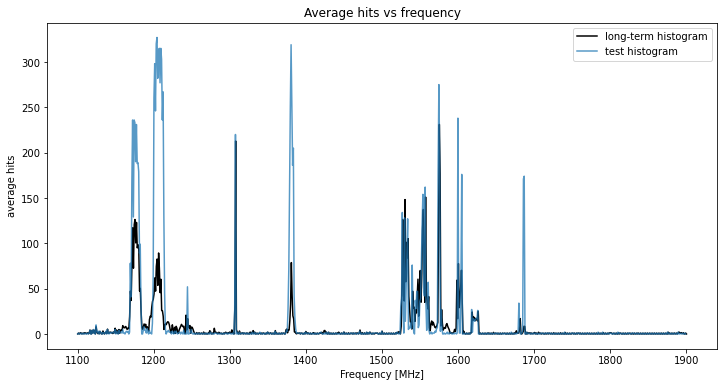

In [23]:
plt.figure(figsize=(12,6))
plt.plot(x, means, color="black", label="long-term histogram")
plt.plot(bins[:-1], hist, alpha=0.75, label="test histogram")
plt.legend()
plt.xlabel("Frequency [MHz]")
plt.ylabel("average hits")
plt.title("Average hits vs frequency")
plt.savefig("mean_with_test.png");

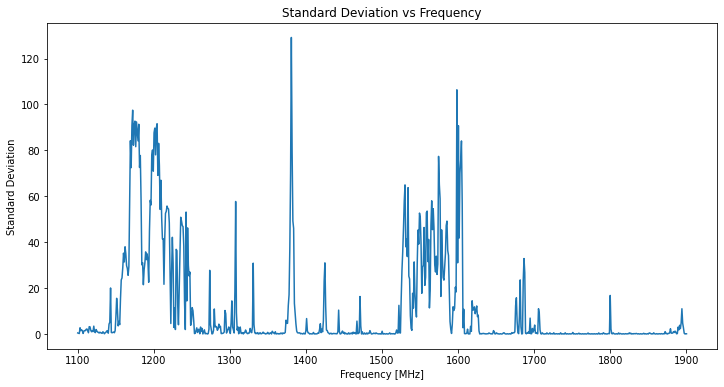

In [24]:
plt.figure(figsize=(12,6))
plt.plot(x, sds)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Standard Deviation")
plt.title("Standard Deviation vs Frequency");

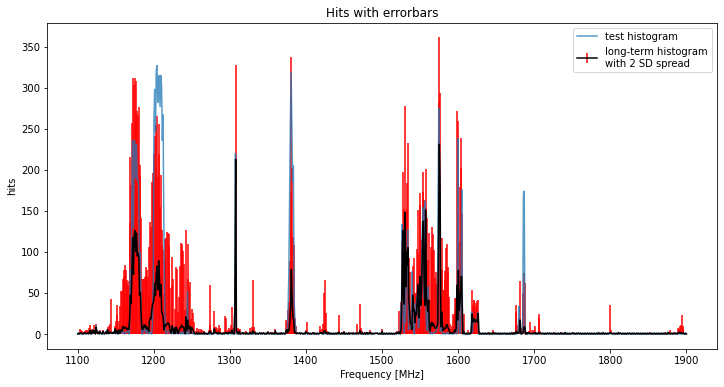

In [25]:
number_sds = 2

# set the floor of the errorbars to be zero, because negative hits is makes no physical sense
floor = np.ones(len(sds))
for i in range(len(sds)):
    floor[i] = max(means[i], (means[i] - number_sds*sds[i]))

plt.figure(figsize=(12,6))
plt.errorbar(x, means, yerr=(floor, number_sds*sds), ecolor="red", color="black", label="long-term histogram\nwith %s SD spread"%number_sds)
plt.plot(bins[:-1], hist, alpha=0.75, label="test histogram")
plt.legend()
plt.xlabel("Frequency [MHz]")
plt.ylabel("hits")
plt.title("Hits with errorbars")
plt.savefig("hist_with_errorbars.png");

In [26]:
def z_score(data, mean, sd):
    return (data - mean)/sd

Looking at the z-score, I'm not sure if the data is just a bad observation, or if the high number of frequencies with very low standard deviations is throwing off the plot

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


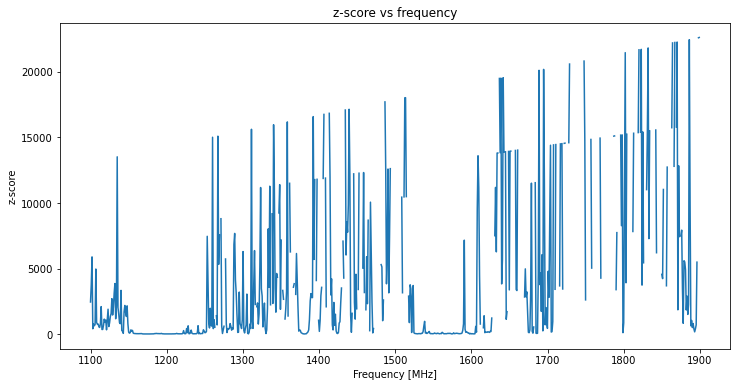

In [27]:
zz = z_score(bins[:-1], means, sds)

plt.figure(figsize=(12,6))
plt.plot(bins[:-1], zz)
plt.title("z-score vs frequency")
plt.xlabel("Frequency [MHz]")
plt.ylabel("z-score");

In [28]:
overshoot = hist-(means+2*sds) > 0
bins[:-1][overshoot]

array([1200.12515645, 1201.12640801, 1202.12765957, 1203.12891114,
       1204.1301627 , 1205.13141427, 1206.13266583, 1207.1339174 ,
       1208.13516896, 1209.13642053, 1210.13767209, 1211.13892365,
       1212.14017522, 1213.14142678, 1339.2991239 , 1377.34668335,
       1378.34793492, 1379.34918648, 1381.35168961, 1382.35294118,
       1383.35419274, 1384.35544431, 1403.37922403, 1419.39924906,
       1489.48685857, 1604.63078849, 1679.72465582, 1685.73216521,
       1686.73341677, 1829.91239049])

In [29]:
undershoot = hist-(means-2*sds)<0
bins[:-1][undershoot]

array([1409.38673342])

In [30]:
def compare_hist(long_term_mean, long_term_sd, length_mean, length_sd, new_dat, GBT_band, n_stand_dev=2, bin_width=1):
    tbl = find.read_dat(new_dat)
    new_length = len(tbl)
    
    hist, bins = spectral_occupancy.calculate_hist("dummy string", GBT_band, bin_width=bin_width, tbl=tbl)
    
    high_indices = (hist - (long_term_mean + n_stand_dev*long_term_sd))>0
    low_indices = (hist - (long_term_mean - n_stand_dev*long_term_sd))<0
    
    low_frequencies = bins[:-1][low_indices]
    high_frequencies = bins[:-1][high_indices]
    
    is_normal_length = new_length > length_mean - n_stand_dev*length_sd  and new_length < length_mean + n_stand_dev*length_sd
    
    return high_frequencies, low_frequencies, is_normal_length

In [31]:
def calculate_long_term_statistics(long_term_dats, GBT_band):
    all_hist = []
    file_lengths = []
    for i in range(len(long_term_dats)):
        hist, _ = spectral_occupancy.calculate_hist(long_term_dats[i], GBT_band)
        tbl = find.read_dat(long_term_dats[i])
        file_lengths.append(len(tbl))
        all_hist.append(hist)
    all_hist = np.asarray(all_hist)
    file_lengths = np.asarray(file_lengths)
    
    transposed = all_hist.T
    means, sds = [],[]
    for freq in transposed:
        one_mean = np.mean(freq)
        one_sd = np.std(freq)

        means.append(one_mean)
        sds.append(one_sd)

    means = np.asarray(means)
    sds = np.asarray(sds)
    return means, sds, np.mean(file_lengths), np.std(file_lengths)

In [32]:
mu, sigma, len_mu, len_sigma = calculate_long_term_statistics(l_dat, "L")
high_freqs, low_freqs, normal_length = compare_hist(mu, sigma, len_mu, len_sigma, l_dat[0], "L", n_stand_dev=2)
if len(high_freqs) > 0:
    print("The following frequencies have hit counts higher than normal:")
    for freq in high_freqs:
        print("\t%s"%freq)
if len(low_freqs) > 0:
    print("\n\nThe following frequencies have hit counts lower than normal:")
    for freq in low_freqs:
        print("\t%s"%freq)

if not normal_length:
    print("This file has fewer entries than normal")

The following frequencies have hit counts higher than normal:
	1295.2440550688361
	1314.2678347934918
	1322.2778473091364
	1488.485607008761
	1530.538172715895
	1616.645807259074
	1622.6533166458073


## The long term histogram and comparison code seems to be working

I will now run the code over all the dats in all the bands from Raffy's paper

In [33]:
def compare_driver(band_list, GBT_band, n_stand_dev=2):
    print("Calculating long term histogram...", end="")
    mu, sigma, len_mu, len_sigma = calculate_long_term_statistics(band_list, GBT_band)
    
    n_high, n_low, is_short = [],[],[]
    for i in trange(len(band_list)):
        high_freqs, low_freqs, normal_length = compare_hist(mu, sigma, len_mu, len_sigma, band_list[i], GBT_band, n_stand_dev)
        n_high.append(len(high_freqs))
        n_low.append(len(low_freqs))
        if not normal_length:
            is_short.append(band_list[i])
    
    return np.asarray(n_high), np.asarray(n_low), is_short

In [34]:
L_high, L_low, L_bad_length = compare_driver(l_dat, "L", 3)
S_high, S_low, S_bad_length = compare_driver(s_dat, "S", 3)
C_high, C_low, C_bad_length = compare_driver(c_dat, "C", 3)
X_high, X_low, X_bad_length = compare_driver(x_dat, "X", 3)

Calculating long term histogram...

100%|██████████| 141/141 [00:17<00:00,  7.98it/s]


Calculating long term histogram...

100%|██████████| 111/111 [00:02<00:00, 43.23it/s]


Calculating long term histogram...

100%|██████████| 96/96 [00:07<00:00, 13.71it/s]


Calculating long term histogram...

100%|██████████| 127/127 [00:05<00:00, 23.32it/s]


In [35]:
max(tbl["CoarseChanNum"])

307

In [36]:
np.argmin(L_high)

10

# To do:

- remove notch filter for L, S bands
- plot waterfall plot along with the histogram
- plot Z-score vs frequency
- make waterfall of low hits/ normal hits/ high hits 